In [1]:
import pickle
import matplotlib.pyplot as plt 

import numpy as np

import torch
from torch import nn

from torchdiffeq import odeint

In [2]:
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)

# Load the data

In [3]:
# load the data from the file

noise_level = '0_1'
noise_scale = 0.1
with open('train_traj_noise' + str(noise_level) + '.p', 'rb') as f:
    train_data = pickle.load(f)

with open('test_traj_noise' + str(noise_level) + '.p', 'rb') as f:
    test_data = pickle.load(f)


In [4]:
X_train = train_data['obs']
X_test = test_data['obs']

time_train = train_data['time']
time_test = test_data['time']

X_train.shape, X_test.shape

((5001, 40), (5001, 40))

In [5]:
K = 40  # Number of globa-scale variables X
J = 5  # Number of local-scale Y variables per single global-scale X variable
nt = 5000  # Number of time steps
si = 0.2  # Sampling time interval
dt = 0.005  # Time step
F = 8.0  # Forcing
h = 1.0  # Coupling coefficient
b = 10.0  # ratio of amplitudes
c = 10.0  # time-scale ratio

k = np.arange(K)  # For coordinate in plots
j = np.arange(J * K)  # For coordinate in plots

In [6]:
localize = True
localization_lengthscale = 20
localization_matrix = np.zeros((K,K))
for i in range(K):
    for j in range(K):
        localization_matrix[i,j] = np.exp(-abs(i-j)**2 / localization_lengthscale)

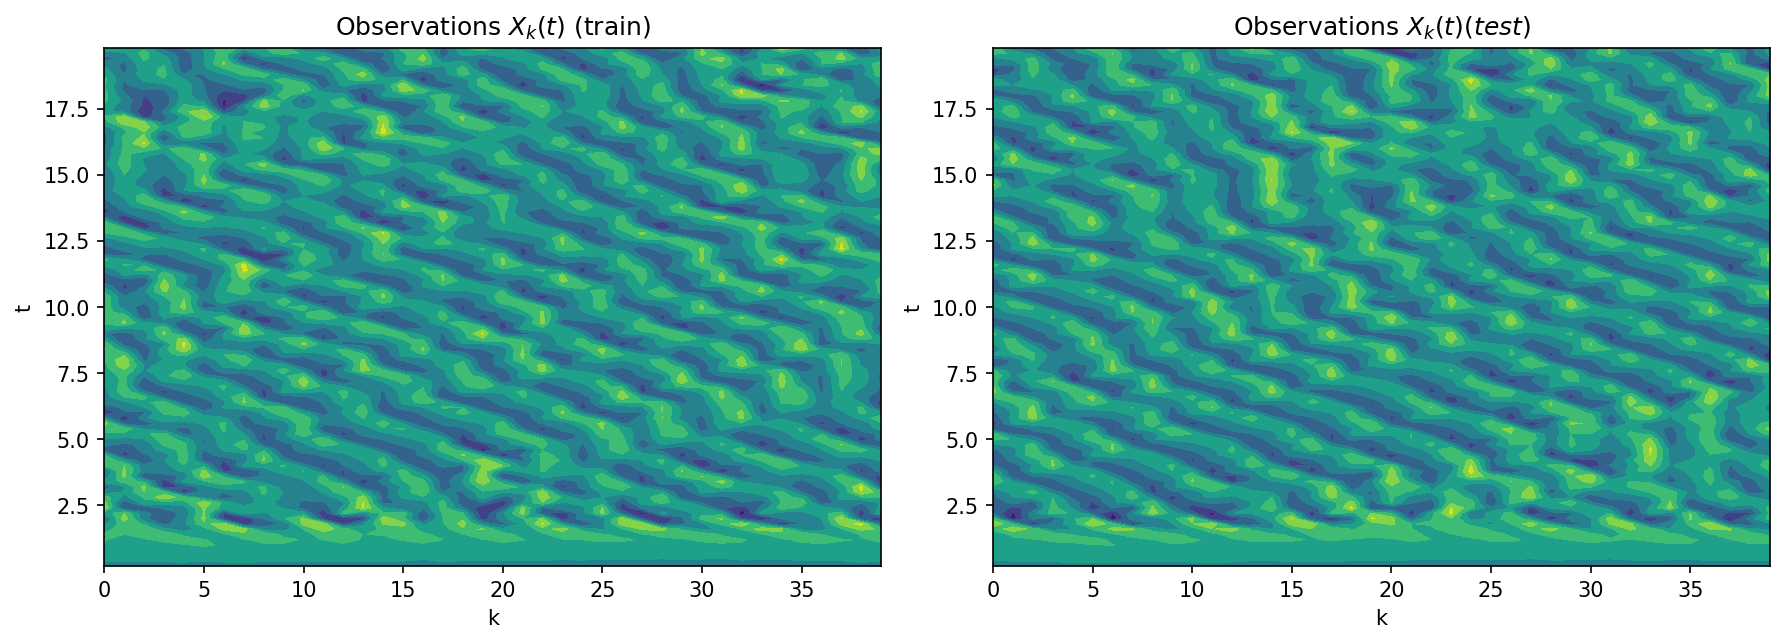

In [7]:
plt.figure(figsize=(12, 8), dpi=150)

time_cutoff = 100


# True X
plt.subplot(221)
plt.contourf(k, time_train[1:time_cutoff], X_train[1:time_cutoff])
plt.xlabel("k")
plt.ylabel("t")
plt.title("Observations $X_k(t)$ (train)")

# True X
plt.subplot(222)
plt.contourf(k, time_test[1:time_cutoff], X_test[1:time_cutoff])
plt.xlabel("k")
plt.ylabel("t")
plt.title("Observations $X_k(t) (test)$")

plt.tight_layout()
plt.show()

# Integrate using torchdiffeq

In [9]:
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)

/tmp/ipykernel_872116/2616400242.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train = torch.tensor(X_train, dtype=torch.float32)
/tmp/ipykernel_872116/2616400242.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_test = torch.tensor(X_test, dtype=torch.float32)


In [13]:
import importlib
import AD_enkf_utils

# Force a reload of the module
importlib.reload(AD_enkf_utils)


from AD_enkf_utils import estimate_log_likelihood, L96_eq1_xdot

In [ ]:
# def L96_eq1_xdot(t, X, F = F, advect=True):
#     """
#     Calculate the time rate of change for the X variables for the Lorenz '96, equation 1:
#         d/dt X[k] = -X[k-2] X[k-1] + X[k-1] X[k+1] - X[k] + F

#     Args:
#         X : Values of X variables at the current time step
#         F : Forcing term
#     Returns:
#         dXdt : Array of X time tendencies
#     """

#     K = len(X)
#     Xdot = torch.zeros(K)

#     if advect:
#         Xdot = torch.roll(X, 1) * (torch.roll(X, -1) - torch.roll(X, 2)) - X + F
#     else:
#         Xdot = -X + F
#     #     for k in range(K):
#     #         Xdot[k] = ( X[(k+1)%K] - X[k-2] ) * X[k-1] - X[k] + F
#     return Xdot

In [14]:
N_particles = 50
model_noise = 0.1
particles = X_train[0] + 0.1 * torch.normal(mean=0, std=1.0, size = (N_particles, K))

In [15]:
odeint(L96_eq1_xdot, particles, torch.tensor([0.0, dt]), method='rk4').shape

torch.Size([2, 50, 40])

In [16]:
# Define our neural network model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(K, 4*K),
            nn.ReLU(),
            nn.Linear(4*K, 4*K),
            nn.ReLU(),
            nn.Linear(4*K, K),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

In [17]:
model = NeuralNetwork()

In [18]:
model(particles).shape, odeint(L96_eq1_xdot, particles, torch.tensor([0.0, dt]), method='rk4')[-1].shape

(torch.Size([50, 40]), torch.Size([50, 40]))

In [19]:
localization_matrix = torch.tensor(localization_matrix, dtype=torch.float32)

In [20]:
noise_scale = 0.1

In [21]:
# def estimate_log_likelihood(model, particles, y_obs, dt, noise_scale, model_noise):
#     nt = y_obs.shape[0]
#     log_est = torch.tensor([0.0])
#     for i in range(nt):
#         # propagate particles one step forward
#         pred = odeint(L96_eq1_xdot, particles, torch.tensor([0.0, dt]), method='rk4')[-1] + model(particles) + torch.normal(mean=0, std=model_noise, size = (N_particles, K))

#         #Compute the empirical covariance matrix
#         cov = torch.cov(pred.T)
#         mean = torch.mean(pred, axis=0)
        
#         if localize:
#             cov = localization_matrix * cov
#         y = y_obs[i]
        
#         # Draw observational noise and correct the particles
#         noise = torch.normal(mean = 0.0, std=noise_scale, size=particles.shape)
#         increment = y - noise - pred
#         correction = cov@torch.linalg.solve(cov + (noise_scale**2)*torch.eye(K), increment.T)
        
#         particles = pred + correction.T

#         # Compute the log-likelihood
#         diff = y - mean
#         log_est += -0.5 * torch.linalg.solve(cov + (noise_scale**2)*torch.eye(K), diff.T).T@diff.T
#     return log_est/nt/K

In [32]:
import importlib
import AD_enkf_utils

# Force a reload of the module
importlib.reload(AD_enkf_utils)


from AD_enkf_utils import estimate_log_likelihood, L96_eq1_xdot

In [36]:
estimate_log_likelihood(model, particles, X_train[:20], dt, noise_scale, model_noise, localization_matrix = localization_matrix)

tensor([-307.2488], grad_fn=<DivBackward0>)

# AutoDiff ENKF

In [49]:
train_length = 500

n_epochs = 10
loss_hist = []

In [50]:
model = NeuralNetwork()
# Initialize the optimizer to be adam
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-2)

In [51]:
X_train.shape

torch.Size([5001, 40])

In [54]:
from AD_enkf_utils import train_model

In [55]:
model, loss_hist = train_model(model, X_train, optimizer, n_epochs, train_length, model_noise, noise_scale, dt, N_particles = 50,localize = True, localization_matrix = localization_matrix)

Epoch 0, Iteration 0, Loss 194.5205535888672
Epoch 0, Iteration 1, Loss 190.6789093017578
Epoch 0, Iteration 2, Loss 184.33297729492188
Epoch 0, Iteration 3, Loss 186.7657012939453
Epoch 0, Iteration 4, Loss 185.16949462890625
Epoch 0, Iteration 5, Loss 184.72714233398438
Epoch 0, Iteration 6, Loss 182.12478637695312
Epoch 0, Iteration 7, Loss 182.0669403076172
Epoch 0, Iteration 8, Loss 176.00894165039062
Epoch 0, Iteration 9, Loss 174.56024169921875
Epoch 1, Iteration 0, Loss 172.77989196777344
Epoch 1, Iteration 1, Loss 168.99658203125
Epoch 1, Iteration 2, Loss 166.39256286621094
Epoch 1, Iteration 3, Loss 164.06060791015625
Epoch 1, Iteration 4, Loss 160.4901885986328
Epoch 1, Iteration 5, Loss 156.58209228515625
Epoch 1, Iteration 6, Loss 152.4769744873047
Epoch 1, Iteration 7, Loss 150.3426055908203
Epoch 1, Iteration 8, Loss 142.72238159179688
Epoch 1, Iteration 9, Loss 139.20614624023438
Epoch 2, Iteration 0, Loss 136.71339416503906
Epoch 2, Iteration 1, Loss 123.9564056396484

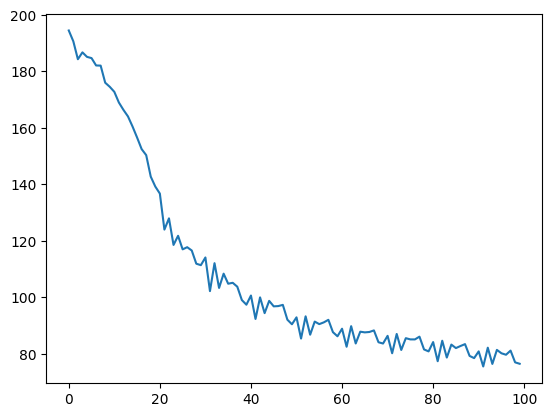

In [56]:
plt.plot(loss_hist)

# Predict on the testing trajectory

In [60]:
model.eval()

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=40, out_features=160, bias=True)
    (1): ReLU()
    (2): Linear(in_features=160, out_features=160, bias=True)
    (3): ReLU()
    (4): Linear(in_features=160, out_features=40, bias=True)
  )
)

In [61]:
forward_model_nn = lambda x: odeint(L96_eq1_xdot, x, torch.tensor([0.0, dt]), method='rk4')[-1] + model(x)

In [95]:
from AD_enkf_utils import filter

In [96]:
x_0 =  X_test[0] + model_noise * torch.normal(mean=0, std=1.0, size = (N_particles, K))

In [97]:
prediction_nn, analysis_nn, correction_nn = filter(forward_model_nn, torch.clone(x_0), X_test[1:], model_noise, noise_scale, model_noise, localize = True, localization_matrix = localization_matrix)

In [121]:
np.mean((np.mean(analysis_nn, axis = 1) - X_test[1:].detach().numpy())**2)

0.7069848

In [122]:
np.mean((np.mean(prediction_nn, axis = 1) - X_test[1:].detach().numpy())**2)

3.8350718

In [100]:
forward_model_vanilla = lambda x: odeint(L96_eq1_xdot, x, torch.tensor([0.0, dt]), method='rk4')[-1]

In [101]:
prediction_vanilla, analysis_vanilla, correction_vanilla = filter(forward_model_vanilla, torch.clone(x_0), X_test[1:], model_noise, noise_scale, model_noise, localize = True, localization_matrix = localization_matrix)

In [102]:
np.mean((np.mean(analysis_vanilla, axis = 1) - X_test[1:].detach().numpy())**2)

1.6162663

In [112]:
np.mean((np.mean(prediction_vanilla, axis = 1) - X_test[1:].detach().numpy())**2)

9.335251

In [131]:
np.mean(((np.mean(prediction_vanilla, axis = 1) - X_test[1:].detach().numpy())**2),axis = -1).shape

(5000,)

# Plots

In [134]:
mean_pred_nn = np.mean(prediction_nn, axis = 1)
mean_pred_vanilla = np.mean(prediction_vanilla, axis = 1)

mean_analysis_nn = np.mean(analysis_nn, axis = 1)
mean_analysis_vanilla = np.mean(analysis_vanilla, axis = 1)

In [137]:
mean_pred_nn.shape

(5000, 40)

In [138]:
y_test = X_test[1:].detach().numpy()

In [152]:
t_start = 0 
t_end = 100

# Calculate global vmin and vmax
all_data = [
    np.abs(mean_pred_nn[t_start:t_end] - y_test[t_start:t_end]),
    np.abs(mean_pred_vanilla[t_start:t_end] - y_test[t_start:t_end]),
    np.abs(mean_analysis_nn[t_start:t_end] - y_test[t_start:t_end]),
    np.abs(mean_analysis_vanilla[t_start:t_end] - y_test[t_start:t_end])
]
vmin = 0.0
vmax = max(data.max() for data in all_data)

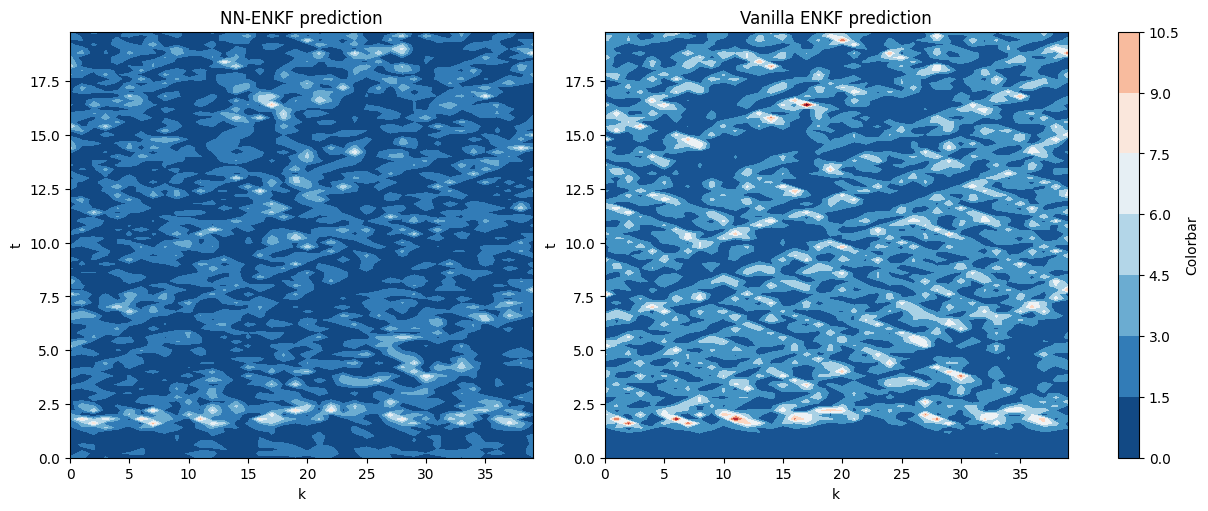

In [151]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), constrained_layout=True)


# Create the contour plots
contour1 = ax1.contourf(k, time_test[t_start:t_end], np.abs(mean_pred_nn[t_start:t_end] - y_test[t_start:t_end]), cmap='RdBu_r', vmin=vmin, vmax=vmax)
contour2 = ax2.contourf(k, time_test[t_start:t_end], np.abs(mean_pred_vanilla[t_start:t_end] - y_test[t_start:t_end]), cmap='RdBu_r', vmin=vmin, vmax=vmax)


# Add a shared colorbar
cbar = fig.colorbar(contour1, ax=[ax1, ax2], orientation='vertical')
cbar.ax.set_ylabel('Colorbar')

# Set titles and labels
ax1.set_title('NN-ENKF prediction')
ax1.set_xlabel('k')
ax1.set_ylabel('t')

ax2.set_title('Vanilla ENKF prediction')
ax2.set_xlabel('k')
ax2.set_ylabel('t')

plt.show()

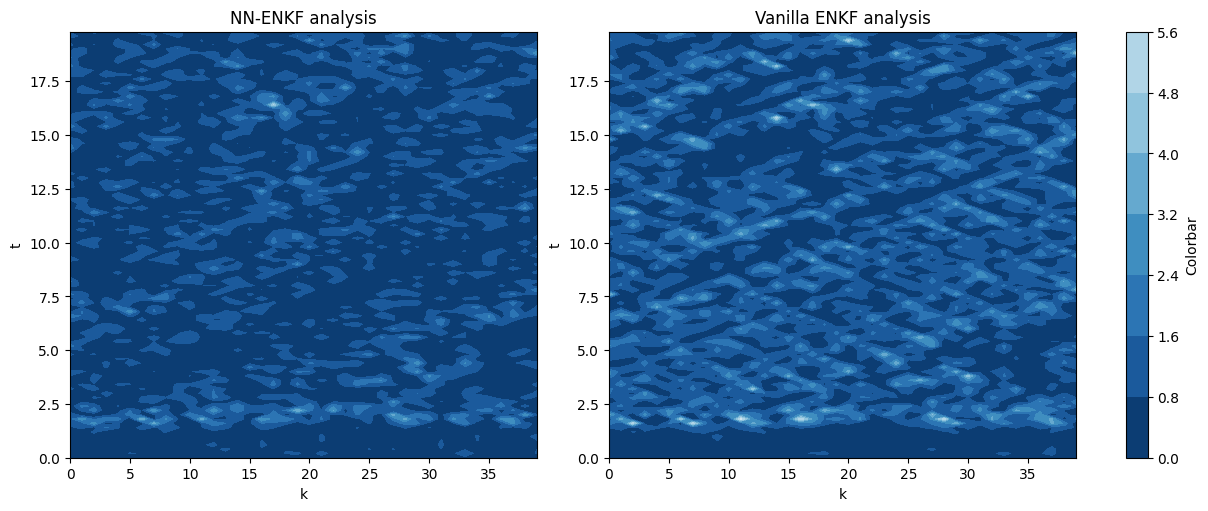

In [153]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), constrained_layout=True)


# Create the contour plots
contour1 = ax1.contourf(k, time_test[t_start:t_end], np.abs(mean_analysis_nn[t_start:t_end] - y_test[t_start:t_end]), cmap='RdBu_r', vmin=vmin, vmax=vmax)
contour2 = ax2.contourf(k, time_test[t_start:t_end], np.abs(mean_analysis_vanilla[t_start:t_end] - y_test[t_start:t_end]), cmap='RdBu_r', vmin=vmin, vmax=vmax)


# Add a shared colorbar
cbar = fig.colorbar(contour1, ax=[ax1, ax2], orientation='vertical')
cbar.ax.set_ylabel('Colorbar')

# Set titles and labels
ax1.set_title('NN-ENKF analysis')
ax1.set_xlabel('k')
ax1.set_ylabel('t')

ax2.set_title('Vanilla ENKF analysis')
ax2.set_xlabel('k')
ax2.set_ylabel('t')

plt.show()

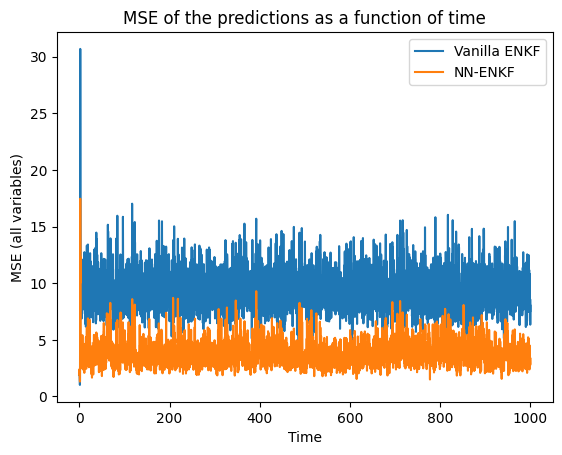

In [161]:
plt.plot(time_test[1:], np.mean(((np.mean(prediction_vanilla, axis = 1) - y_test)**2),axis = -1), label = "Vanilla ENKF")
plt.plot(time_test[1:], np.mean(((np.mean(prediction_nn, axis = 1) -y_test)**2),axis = -1), label = "NN-ENKF")

plt.title("MSE of the predictions as a function of time")
plt.xlabel("Time")
plt.ylabel("MSE (all variables)")
plt.legend()
plt.show()

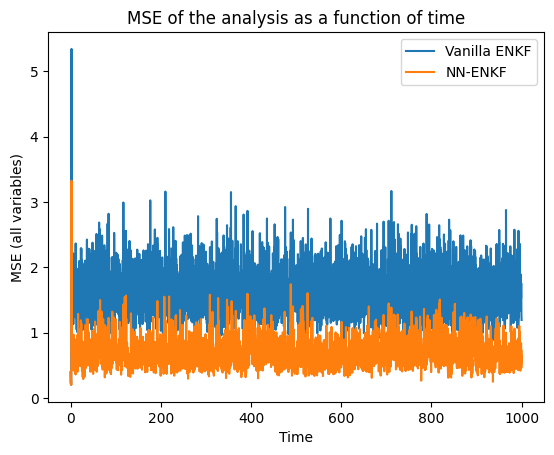

In [162]:
plt.plot(time_test[1:], np.mean(((np.mean(analysis_vanilla, axis = 1) - y_test)**2),axis = -1), label = "Vanilla ENKF")
plt.plot(time_test[1:], np.mean(((np.mean(analysis_nn, axis = 1) -y_test)**2),axis = -1), label = "NN-ENKF")

plt.title("MSE of the analysis as a function of time")
plt.xlabel("Time")
plt.ylabel("MSE (all variables)")
plt.legend()
plt.show()

# Every noise level

In [167]:
import importlib
import AD_enkf_utils

# Force a reload of the module
importlib.reload(AD_enkf_utils)
from AD_enkf_utils import train_model

Noise level:  0.1


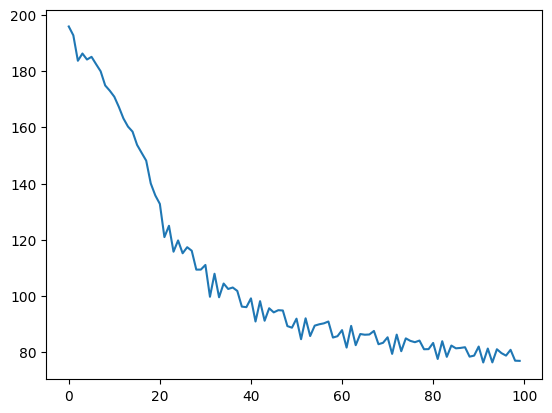

NN: Prediction error 3.8362650871276855, analysis error 0.7077765464782715
Vanilla: Prediction error 9.33780574798584, analysis error 1.6203210353851318
Noise level:  0.5


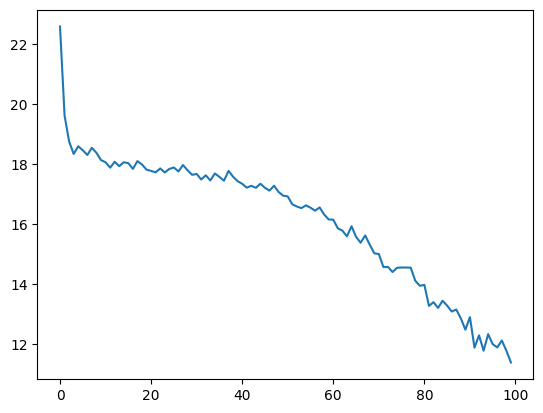

NN: Prediction error 6.59029483795166, analysis error 0.013354267925024033
Vanilla: Prediction error 8.015007972717285, analysis error 0.016269925981760025
Noise level:  1.0


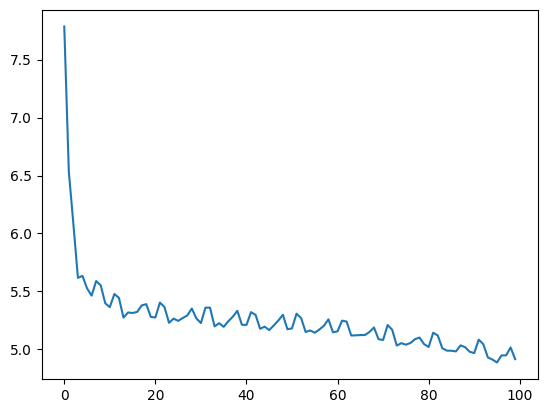

NN: Prediction error 9.058632850646973, analysis error 0.0014890023740008473
Vanilla: Prediction error 9.256800651550293, analysis error 0.0015351047040894628
Noise level:  2.0


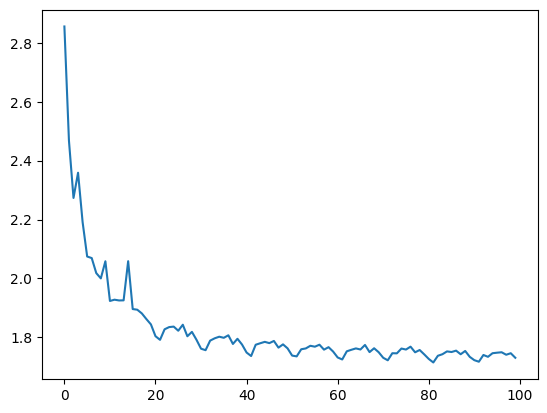

NN: Prediction error 15.378081321716309, analysis error 0.00034233168116770685
Vanilla: Prediction error 15.417481422424316, analysis error 0.00034262295230291784


In [168]:
noise_levels = [0.1, 0.5, 1.0, 2.0]
noise_levels_str = ['0_1', '0_5', '1_0', '2_0']

for i in range(len(noise_levels)):


    noise_scale = noise_levels[i]
    noise_level = noise_levels_str[i]

    print("Noise level: ", noise_scale) 

    with open('train_traj_noise' + str(noise_level) + '.p', 'rb') as f:
        train_data = pickle.load(f)

    with open('test_traj_noise' + str(noise_level) + '.p', 'rb') as f:
        test_data = pickle.load(f)

    model = NeuralNetwork()
    # Initialize the optimizer to be adam
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-2)

    X_train = torch.tensor(train_data['obs'], dtype=torch.float32)
    X_test = torch.tensor(test_data['obs'], dtype=torch.float32)
    y_test = X_test[1:].detach().numpy()

    time_train = train_data['time']

    model, loss_hist = train_model(model, X_train, optimizer, n_epochs, train_length, model_noise, noise_scale, dt, N_particles = 50,localize = True, localization_matrix = localization_matrix, verbose = False)
    plt.figure()
    plt.plot(loss_hist)
    plt.show()

    # Filter with the trained model
    model.eval()
    forward_model_nn = lambda x: odeint(L96_eq1_xdot, x, torch.tensor([0.0, dt]), method='rk4')[-1] + model(x)
    x_0 =  X_test[0] + model_noise * torch.normal(mean=0, std=1.0, size = (N_particles, K))
    prediction_nn, analysis_nn, correction_nn = filter(forward_model_nn, torch.clone(x_0), X_test[1:], model_noise, noise_scale, model_noise, localize = True, localization_matrix = localization_matrix)
    
    print("NN: Prediction error {}, analysis error {}".format(np.mean((np.mean(prediction_nn, axis = 1) - y_test)**2), np.mean((np.mean(analysis_nn, axis = 1) - y_test)**2)))
    
    # Filter with the vanilla model
    forward_model_vanilla = lambda x: odeint(L96_eq1_xdot, x, torch.tensor([0.0, dt]), method='rk4')[-1]
    prediction_vanilla, analysis_vanilla, correction_vanilla = filter(forward_model_vanilla, torch.clone(x_0), X_test[1:], model_noise, noise_scale, model_noise, localize = True, localization_matrix = localization_matrix)

    print("Vanilla: Prediction error {}, analysis error {}".format(np.mean((np.mean(prediction_vanilla, axis = 1) - y_test)**2), np.mean((np.mean(analysis_vanilla, axis = 1) - y_test)**2)))


    


# 